In [1]:
#Universidad Nacional Autónoma de México
#Posgrado en Ciencias de la Tierra 
#Campo 1, Geofísica de la Tierra sólida, Sismología

#Elaborado por Isaac Valverde, 2022

#Programa 1: Notebook de Python 3 que ajusta datos sintéticos al modelo de una recta usando el método de inferencia bayesiana (IB) muestreando la posterior con cadenas de Markov-Monte Carlo (MCMC) 
#Basado en el ejemplo: https://adrian.pw/blog/fitting-a-line/

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Función que evalúa una pdf normal de los residuos (verosimilitud)
#Entradas
#parametros: Arreglo numpy que contiene los dos parámetros del modelo de una recta [pendiente, ordenada al origen].
#x: Arreglo numpy que contiene los puntos sobre el eje de las abscisas de cada observación.
#y: Arreglo numpy que contiene los datos observados.
#yerr: Arreglo numpy que contiene la desviación estandar de cada observación.
#Salida
#lk: Logaritmo natural de la muestra de la verosimilitud

def ln_likelihood(parametros,x,y,yerr):
    #Se define el número de parámetros
    N=len(y)
    #Se define la pendiente como la variable "m"
    m=parametros[0]
    #Se define la ordenada al origen como la variable "b"
    b=parametros[1]
    #Se obtiene el residuo (diferencia entre los datos observados y los datos obtenidos mediante la evaluación del modelo directo).
    dy=y-(parametros[0]*x+parametros[1]) 
    #Inverso de la varianza
    ivar=1/yerr**2 
    #Verosimilitud del logaritmo de una distribución normal (gaussiana)
    lk=-0.5*(N*np.log(2*np.pi)+np.sum(2*np.log(yerr))+np.sum(dy**2*ivar))
    return lk

In [4]:
#Función que evalúa una pdf uniforme para los parámetros (apriori)
#Entradas
#parametros: Arreglo numpy que contiene los dos parámetros del modelo de una recta [pendiente, ordenada al origen].
#Salida
#ln_prior_val: Logaritmo natural de la muestra de la apriori

def ln_prior(parametros): 
    
        #Se define la pendiente como la variable "m"
        m=parametros[0]
        #Se define la ordenada al origen como la variable "b"
        b=parametros[1]
        #Se inicializa la variable "ln_prior_val" en cero
        ln_prior_val=0 
        
        #Se establece un espacio de parámetros para la pendiente [0,100]
        if m < 0 or m > 100:
            return -np.inf
        else:
            ln_prior_val=ln_prior_val+np.log(1/(100-0)) #Debido a que la apriori se define como una uniforme, la pdf de una uniforme se define como 1/(b-a), donde a es el límite inferior (0) y b el superior (100) del intervalo en el que esta definido la pdf 

        #Se establece un espacio de parámetros para la ordenada al origen [-50,50]
        if b < -50 or b > 50:
            return -np.inf
        else:
            ln_prior_val=ln_prior_val+np.log(1/(50-(-50))) #Debido a que la apriori se define como una uniforme, la pdf de una uniforme se define como 1/(b-a), donde a es el límite inferior (-50) y b el superior (50) del intervalo en el que esta definido la pdf

        return ln_prior_val

In [5]:
#Función que obtiene una muestra de una pdf posterior calculada a partir de la apriori y la verosimilitud usando el teorema de Bayes
#Entradas
#parametros: Arreglo numpy que contiene los dos parámetros del modelo de una recta [pendiente, ordenada al origen].
#Salida
#lnprob: Muestra de la posterior

def ln_posterior(parametros,x,y,yerr):  
    
        #Se obtiene la distribución a priori    
        lnp=ln_prior(parametros)
        
        #Se revisa si la a priori contiene valores inf
        if np.isinf(lnp): 
            return lnp

        #Se obtiene la verosimilitud
        lnL=ln_likelihood(parametros,x,y,yerr)
        
        #Suma de la log verosimilitud más la log a priori (la multiplicación se vuelve suma por los logaritmos)
        lnprob=lnp+lnL

        #Se verifica que el arreglo no contenga elementos NAN
        if np.isnan(lnprob):
            return -np.inf

        return lnprob

In [6]:
#Se inicializa un generador de números aleatorios
semilla=2023

In [7]:
rnd=np.random.RandomState(seed=semilla)
#Se define el número de observaciones
Nd=25
#Se define la pendiente del modelo ideal
m=1.256
#Se define la ordenada al origen del modelo ideal
b=4.507
#Se generan aleatoriamente "Nd" valores para x
x=rnd.uniform(0,2,Nd)
#Se ordenan los valores aleatorios que se generan para el dominio de la variable (de menor a mayor)
x.sort() 
#Evaluación del modelo para obtener los valores del modelo ideal
y=m*x+b
#Se define un vector de variaciones de una distribución uniforme (Incertidumbre heterocedástica)
yerr=rnd.uniform(0.1,0.2,size=Nd) #Se generan números aleatorios de una distribución uniforme de 0.1 a 0.2
#Remuestreo de los datos con ruido
ys=rnd.normal(y, yerr) #Se generan números aleatorios de una distribución normal centrados en y y con desviación estandar yerr

#Notas:
#yerr:Vector que contiene números aletorios de una distribución uniforme que corresponden a la desviación estandar de cada dato
#ys:Vector que contiene los datos observados sintéticos.

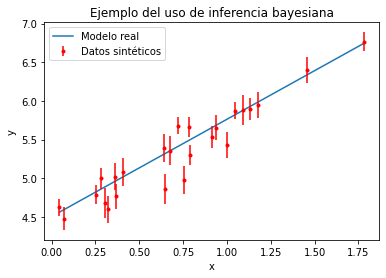

In [8]:
#Gráfica de los datos sintéticos

xreal=np.linspace(np.amin(x),np.amax(x),Nd)
yreal=m*xreal+b
plt.plot(xreal,yreal,label="Modelo real")
plt.errorbar(x,ys,yerr=yerr,label="Datos sintéticos",fmt='r.')
plt.title("Ejemplo del uso de inferencia bayesiana")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig("Datos1.png",dpi=720)
plt.show()

In [9]:
#Se define una semilla de números aleatorios para generar resultados reproducibles
rnd=np.random.RandomState(seed=semilla)
#Se define una propuesta inicial [pendiente,ordenada al origen]
p0=[7,5]
#La propuesta se convierte a un objeto numpy array
p0=np.array(p0)
#Se define el número de muestras a generar con MCMC
Nc=9000
#Se define un arreglo para los datos generados con el muestreo
MCMC=np.zeros([Nc,len(p0)]) 
#Se define un arreglo para las muestras de la posterior
ln_probs=np.zeros(Nc) 
#Se define la primer muestra de la posterior a partir de la primer propuesta para los parámetros
ln_probs[0]=ln_posterior(p0,x,ys,yerr)
#Se asigna la primer propuesta el primer elemento de la cadena 
MCMC[0]=p0    
    
#Ciclo que realiza el MCMC
for i in range(1,Nc):
    #Se calculan las perturbaciones para los parámetros
    pert=rnd.normal(0.,[0.05,0.05])
    #Se perturban los parámetros
    propuesta=MCMC[i-1]+pert
    #Se obtiene la distribución posterior de los parámetros perturbados
    Newlnprob=ln_posterior(propuesta,x,ys,yerr)
    #Se obtiene la relación entre los parámetros perturbados y los de la iteración anterior
    Ratiolnprob=Newlnprob-ln_probs[i-1]
    #Criterio de metrópolis
    if (Ratiolnprob > 0) or (Ratiolnprob>np.log(rnd.uniform())):
        MCMC[i]=propuesta
        ln_probs[i]=Newlnprob
    else:
        MCMC[i]=MCMC[i-1]
        ln_probs[i]=ln_probs[i-1]

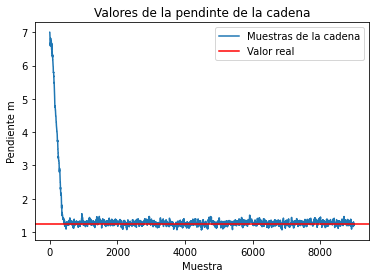

In [10]:
#Curva de convergencia para la pendiente

plt.plot(MCMC[:,0],label="Muestras de la cadena")
plt.axhline(m,color='r',label="Valor real")
plt.title("Valores de la pendinte de la cadena")
plt.ylabel("Pendiente m")
plt.xlabel("Muestra")
plt.legend()
plt.savefig("Quemadom1.png",dpi=720)
plt.show()

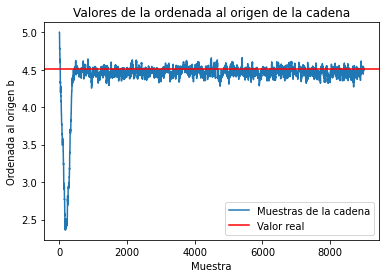

In [11]:
#Curva de convergencia para la ordenada al origen

plt.plot(MCMC[:,1],label="Muestras de la cadena")
plt.axhline(b,color='r',label="Valor real")
plt.title("Valores de la ordenada al origen de la cadena")
plt.ylabel("Ordenada al origen b")
plt.xlabel("Muestra")
plt.legend()
#plt.savefig("Quemadob1.png",dpi=720)
plt.show()

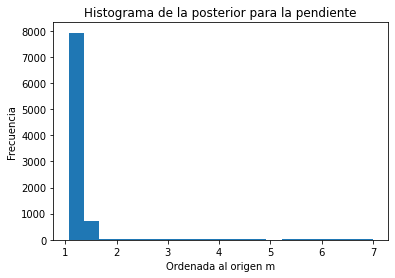

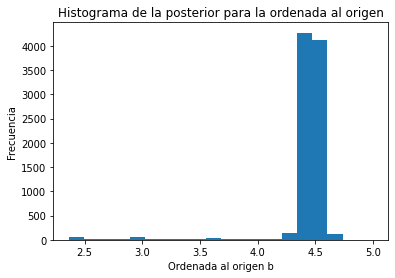

In [12]:
#Se muestran los histogramas de las cadenas sin retirar muestras

plt.hist(MCMC[:,0],bins=20)
plt.title("Histograma de la posterior para la pendiente")
plt.ylabel("Frecuencia")
plt.xlabel("Ordenada al origen m")
plt.show()

plt.hist(MCMC[:,1],bins=20)
plt.title("Histograma de la posterior para la ordenada al origen")
plt.ylabel("Frecuencia")
plt.xlabel("Ordenada al origen b")
plt.show()

In [13]:
#Se eliminan las primeras 450 muestras de la cadena (quemado)
MCMC1=MCMC[450:]

In [14]:
#Se obtiene la mediana de las cadenas para ambos parámetros
med=np.percentile(MCMC1,50, axis=0)

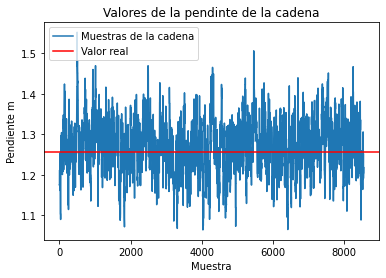

In [15]:
#Curva de convergencia para la pendiente sin las primeras muestras

plt.plot(MCMC1[:,0],label="Muestras de la cadena")
plt.axhline(m,color='r',label="Valor real")
plt.title("Valores de la pendinte de la cadena")
plt.ylabel("Pendiente m")
plt.xlabel("Muestra")
plt.legend()
#plt.savefig("Quemadom.png")
plt.show()


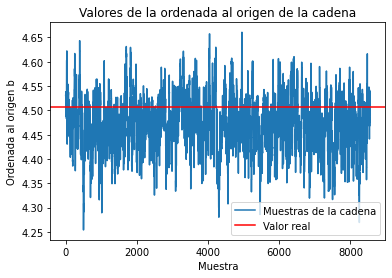

In [16]:
#Curva de convergencia para la ordenada al origen sin las primeras muestras

plt.plot(MCMC1[:,1],label="Muestras de la cadena")
plt.axhline(b,color='r',label="Valor real")
plt.title("Valores de la ordenada al origen de la cadena")
plt.ylabel("Ordenada al origen b")
plt.xlabel("Muestra")
plt.legend()
#plt.savefig("Quemadob.png")
plt.show()

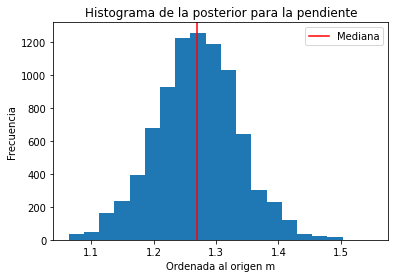

In [17]:
#Histograma de la posterior para la pendiente

plt.hist(MCMC1[:,0],bins=20)
plt.axvline(med[0],color='r',label="Mediana")
plt.title("Histograma de la posterior para la pendiente")
plt.ylabel("Frecuencia")
plt.xlabel("Ordenada al origen m")
plt.legend()
plt.savefig("Histm1.png",dpi=720)
plt.show()

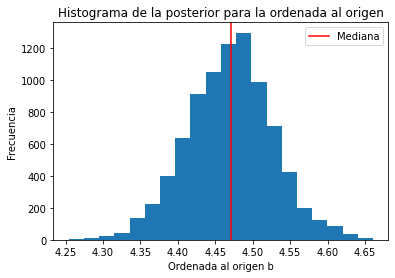

In [18]:
#Histograma de la posterior para la ordenada al origen

plt.hist(MCMC1[:,1],bins=20)
plt.axvline(med[1],color='r',label="Mediana")
plt.title("Histograma de la posterior para la ordenada al origen")
plt.ylabel("Frecuencia")
plt.xlabel("Ordenada al origen b")
plt.legend()
plt.savefig("Histb1.png",dpi=720)
plt.show()

In [19]:
#Se muestran la mediana y la media de la distribución para la pendiente
print(med[0])
print(np.mean(MCMC1[:,0], axis=0))

1.2700287392898117
1.2693862491930057


In [20]:
#Se muestran la mediana y la media de la distribución para la ordenada al origen 
print(med[1])
print(np.mean(MCMC1[:,1], axis=0))

4.471386428324051
4.469669738737329


In [21]:
#Se obtienen los parámetros con una aproximación con mínimos cuadrados
MinCuad=np.polyfit(x,ys,deg=1)

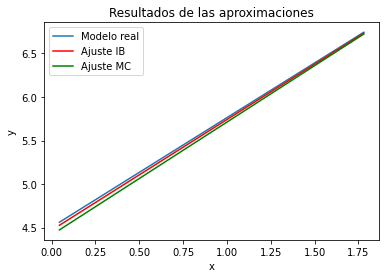

In [22]:
#Se despliega una gráfica comparativa de las rectas con los parámetros obtenidos con ambos métodos

#Valores de la recta calculada con los parámetros ajustados utilizando inferencia bayesiana
ybayes=xreal*med[0]+med[1]
#Valores de la recta calculada con los parámetros ajustados utilizando mínimos cuadrados
yMinCuad=xreal*MinCuad[0]+MinCuad[1]

plt.plot(xreal,yreal,label="Modelo real")
plt.plot(xreal,ybayes,label="Ajuste IB",color="red")
plt.plot(xreal,yMinCuad,label="Ajuste MC",color="green")
plt.title("Resultados de las aproximaciones")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
#plt.savefig("Resultados1.png",dpi=700)
plt.show()
